# Baseline

Рассмотрим базовые модели алгоритмов и их лучшие метрики для предсказания трудоустройства людей из выборки в течение года.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
import shap

# Импортируем функции расчета метрик классификации из модуля
from get_metrics import get_metrics_classification, accuracy_score,log_loss, roc_auc_score, mean_absolute_error, f1_score

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Функция для проверки переобучения
def check_overfitting(metric_fun,
                      y_train,
                      y_test,
                      X_train=None,
                      X_test=None,
                      model=None,
                      y_train_proba=None,
                      y_test_proba=None):
    """
    Проверка на overfitting
    """
    if model is None:
        value_train = metric_fun(y_train, y_train_proba)
        value_test = metric_fun(y_test, y_test_proba)
    else:
        if metric_fun.__name__ == 'roc_auc_score':
            y_pred_train = model.predict_proba(X_train)[:, 1]
            y_pred_test = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
        value_train = metric_fun(y_train, y_pred_train)
        value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [3]:
# Установим в самом начале глобальные переменные (параметры)
RAND = 10
N_FOLDS = 5

In [4]:
# Импорт данных (таблицы из файла)
df = pd.read_csv('Train.csv')

# EDA

In [5]:
# Более подробно описание рассмотренно в ноутбуке с EDA.
# Ещё раз выведем общую информация о признаках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Person_id        4020 non-null   object 
 1   Survey_date      4020 non-null   object 
 2   Round            4020 non-null   int64  
 3   Status           4020 non-null   object 
 4   Tenure           2626 non-null   float64
 5   Geography        4020 non-null   object 
 6   Province         4020 non-null   object 
 7   Matric           3012 non-null   float64
 8   Degree           2189 non-null   float64
 9   Diploma          2211 non-null   float64
 10  Schoolquintile   2359 non-null   float64
 11  Math             997 non-null    object 
 12  Mathlit          1353 non-null   object 
 13  Additional_lang  2018 non-null   object 
 14  Home_lang        381 non-null    object 
 15  Science          732 non-null    object 
 16  Female           4020 non-null   int64  
 17  Sa_citizen    

In [6]:
df.describe()

,Round,Tenure,Matric,Degree,Diploma,Schoolquintile,Female,Sa_citizen,Birthyear,Birthmonth,Target
count,4020.000000,2626.000000,3012.000000,2189.000000,2211.000000,2359.000000,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000
mean,3.129851,582.883092,0.850598,0.078118,0.081411,2.696482,0.564428,0.999502,1997.462935,5.344030,0.271891
std,0.978014,621.220657,0.356544,0.268418,0.273527,1.318409,0.495893,0.022302,4.378334,3.805916,0.444989
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1972.000000,1.000000,0.000000
25%,2.000000,95.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,1995.000000,1.000000,0.000000
50%,3.000000,395.000000,1.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1999.000000,5.000000,0.000000
75%,4.000000,819.000000,1.000000,0.000000,0.000000,4.000000,1.000000,1.000000,2000.000000,9.000000,1.000000
max,4.000000,3560.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,2004.000000,12.000000,1.000000


По результатам EDA подготовим признаки для обучения алгоритмов

In [7]:
def fullfeat(data: pd.DataFrame):
    '''Функция для обработки предсказаний тестового набора'''

    # Удаляем неинформативные признаки: ID, Дату опроса и столбец, 
    # в котором практически все значения одинаковые.
    data = data.drop(["Person_id", "Survey_date", "Sa_citizen", "Round"], axis=1)

    # Часть пропусков можно заполнить нулями
    data['Tenure'] = np.where(data.Status == 'studying', 0, data.Tenure)
    data['Tenure'] = np.where(data.Status == 'other', 0, data.Tenure)

    # Остальные в признаке заполняем модой
    data.Tenure = data.Tenure.fillna(data.Tenure.mode())
    return data

In [8]:
df = fullfeat(df)

Проверим распределение числовых, не бинарных  признаков на нормальность.

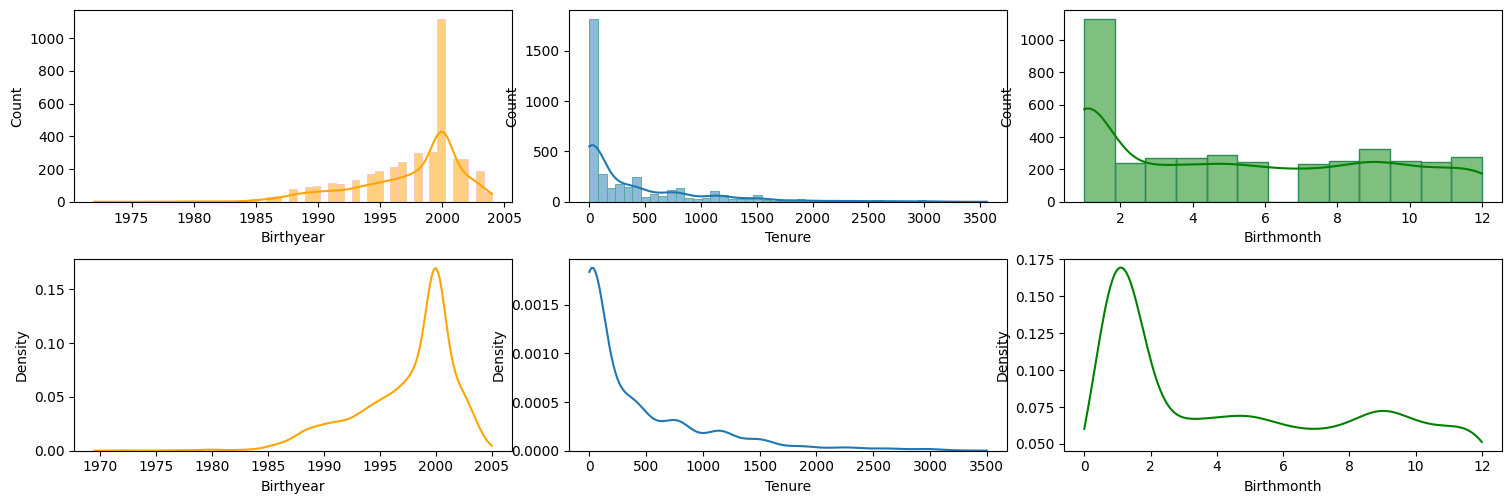

In [9]:
# С помощью гистплотов
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 5))
fig. tight_layout (h_pad= 2 )

sns.histplot(df['Birthyear'], kde=True, color='orange', edgecolor='pink', ax=axes[0][0])
sns.histplot(df['Tenure'], kde=True, ax=axes[0][1], edgecolor='#5A9')
sns.histplot(df['Birthmonth'], kde=True, ax=axes[0][2], color='green', edgecolor='seagreen')

# И графиков плотности
sns.kdeplot(df['Birthyear'], color='orange', ax=axes[1][0], clip = (0, 2005))
sns.kdeplot(df['Tenure'],  ax=axes[1][1], clip = (0, 3500))
sns.kdeplot(df['Birthmonth'], ax=axes[1][2], clip = (0, 12), color='green')
plt.show()

Распределения количества значений признаков ненормальные, имеются выборсы. Учтем это в дальнейшем и при обучении моделей. Распределения так же ненормальные, прологарифмируем признаки.

In [10]:
# Создадим копию датасета для обучения на логарифмированных признаках
dfl = df.copy()

In [11]:
dfl['Birthyear'] = np.log(df['Birthyear'] + 1)
dfl['Tenure'] = np.log(df['Tenure'])
dfl['Birthmonth'] = np.log(df['Birthmonth'])

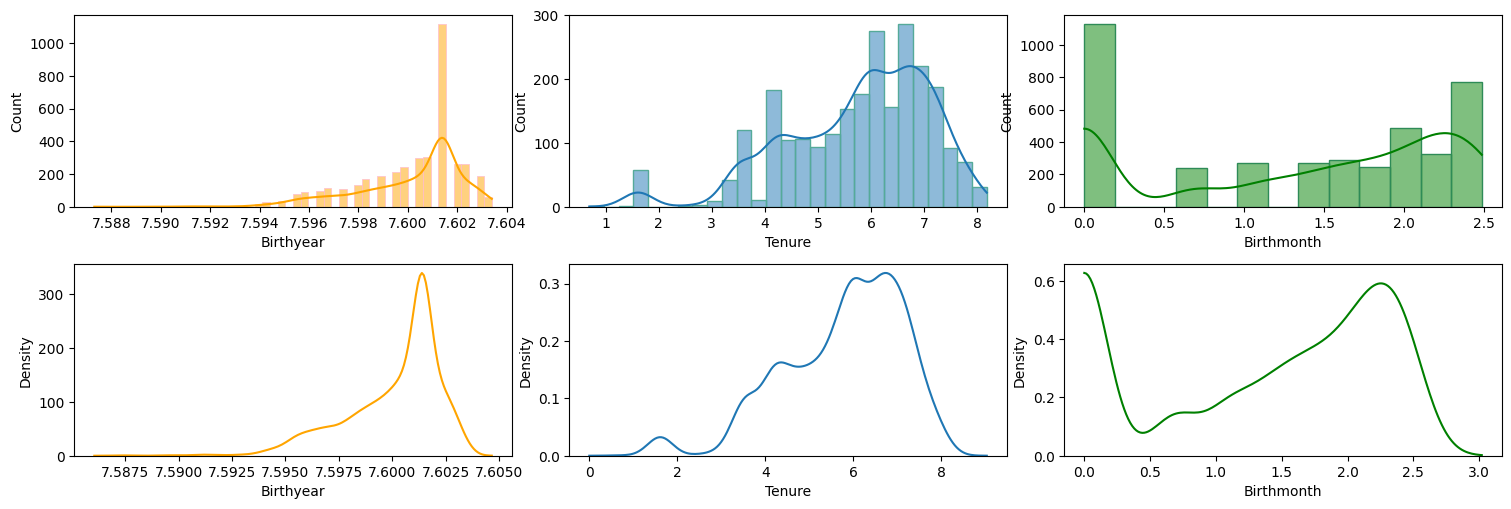

In [12]:
# С помощью гистплотов
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 5))
fig. tight_layout (h_pad= 2 )

sns.histplot(dfl['Birthyear'], kde=True, color='orange', edgecolor='pink', ax=axes[0][0])
sns.histplot(dfl['Tenure'], kde=True, ax=axes[0][1], edgecolor='#5A9')
sns.histplot(dfl['Birthmonth'], kde=True, ax=axes[0][2], color='green', edgecolor='seagreen')

# И графиков плотности
sns.kdeplot(dfl['Birthyear'], color='orange', ax=axes[1][0], clip = (0, 2005))
sns.kdeplot(dfl['Tenure'],  ax=axes[1][1], clip = (0, 3500))
sns.kdeplot(dfl['Birthmonth'],  ax=axes[1][2], color='green', clip = (0, 12))

plt.show()

После логарифмирования распределения немного приблизились к нормальным, признак "Месяц рождения" стал ровнее, но распределние частот далеко от нормального, поэтому его логарифм не будем использовать, потенцируем  обратно. 

In [13]:
dfl['Birthmonth'] = np.exp(dfl['Birthmonth'])

In [14]:
# Заполним пропуски в признаке Tenure на основании EDA
dfl.loc[dfl['Tenure'] < 0, 'Tenure'] = 0
dfl['Tenure'] = dfl['Tenure'].fillna(dfl.Tenure.mode()[0])
df['Tenure'] = df['Tenure'].fillna(df.Tenure.mode()[0])

In [15]:
# Заполним пропуски в остальных признаках значением 'None', т.к. они либо категориальные, либо бинарные.
dfl = dfl.fillna('None')
df = df.fillna('None')

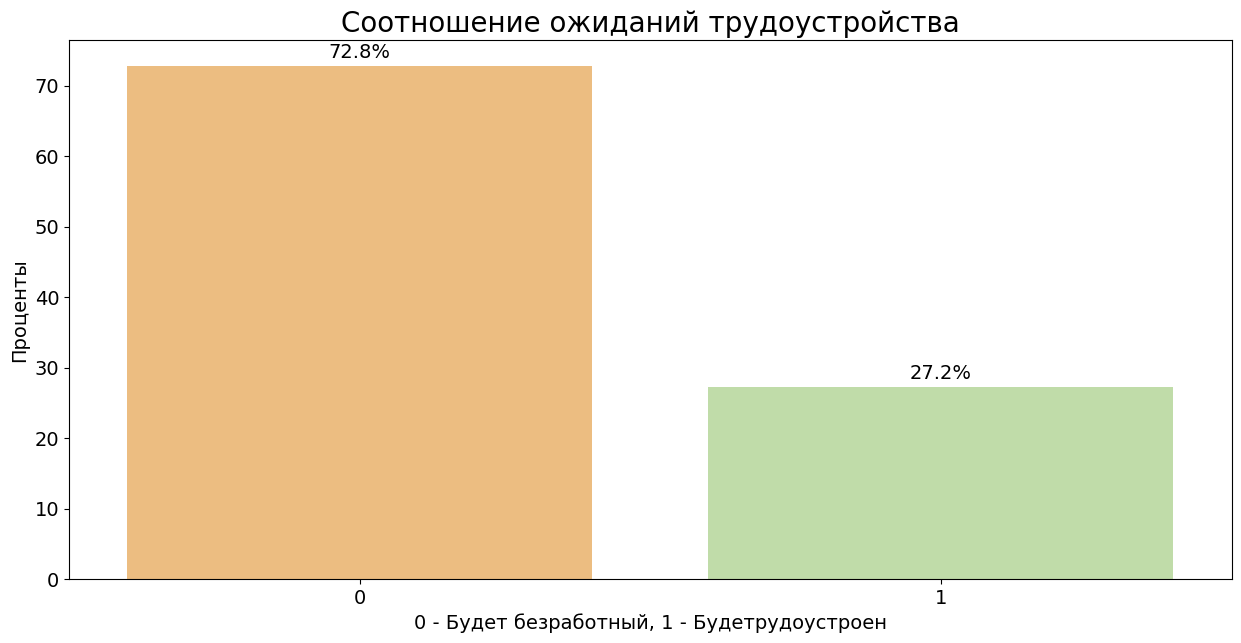

In [16]:
# Из исследовательской части выявлен дизбаланс классов целевой переменной.
# Снова нормируем на размер датасета
norm_target = (dfl['Target'].value_counts(
    normalize=True).mul(100).rename('percent').reset_index())

# Вывод фигуры графика
plt.figure(figsize=(15, 7))
ax = sns.barplot(x=dfl.Target, y='percent', data=norm_target, palette='Spectral')

# Вывод надписей
for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)

plt.title('Соотношение ожиданий трудоустройства', fontsize=20)
plt.xlabel('0 - Будет безработный, 1 - Будетрудоустроен', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

В датесете присутствует дисбаланс классов. Это необходимо учитывать при обучении моделей.

# Обучение моделей baseline

Рассмортим обучение наиболее оптимальных моделей для категориаьных признаков - LGBM и Catboost

In [17]:
# Для обучения модели LGBM переводим признаки из типа object в category
df_cat = dfl.copy()
cat_cols = df_cat.select_dtypes('object').columns
df_cat[cat_cols] = df_cat[cat_cols].astype("category")

In [18]:
# Попробуем обучить LGBM
# Задаем X - исследуемая таблица без целевого признака
X = df_cat.drop(['Target'], axis=1)

# Целевая переменная (зависимая) Y - столбец с признаком, которые необходимо будет предсказать
y = df_cat['Target']

# Разобъем датасет на тренировочные и тестовые данные и так как имеет место дизбаланс классов, 
#так же передаем параметр stratify = y, чтобы сохранить исходное соотношение классов в train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

In [19]:
# Для бинарной классификации импортируем алгоритм LGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

dtrain = lgb.Dataset(X_train, label=y_train)
train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)

# Создаем эксземпляр класса
lgbm = LGBMClassifier(random_state=RAND, scale_pos_weight=ratio, early_stopping_rounds=100)
eval_set = [(X_val, y_val)]

# Обучаем алгоритм на "сырых" признаках, не бинаризованных
lgbm.fit(X_train,
        y_train,
        eval_metric="auc",
        eval_set=eval_set)


[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 874, number of negative: 2342
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 3216, number of used features: 16
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271766 -> initscore=-0.985680
[LightGBM] [Info] Start training from score -0.985680
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.977813	valid_0's binary_logloss: 0.26

LGBMClassifier(early_stopping_rounds=100, random_state=10,
               scale_pos_weight=2.679633867276888)

In [20]:
# Потенцируем признаки для сравнения результатов обучения
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

y_pred = lgbm.predict(X_test)
y_score = lgbm.predict_proba(X_test)

# Выводим метрики в датафрейм
metrics = get_metrics_classification(y_test,
                                         y_pred,
                                         y_score,
                                         name='LGBM_baseline_RAW')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_baseline_RAW,0.745025,0.788744,0.531532,0.538813,0.535147,0.499005


In [21]:
# Проверим переобучение
check_overfitting(model=lgbm,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  metric_fun=roc_auc_score)

roc_auc_score train: 0.980
roc_auc_score test: 0.789
delta = 24.3 %


Переобучение базового алгоритма очень высокое, большая разница между результатами на треничровочных и тестовых данных

In [22]:
# Теперь бинаризуем признаки
n = dfl.loc[:, ~dfl.columns.isin(['Tenure', 'Birthyear', 'Birthmonth', 'Target'])]
n = pd.get_dummies(n)
df_catb = pd.concat([n, dfl[['Tenure', 'Birthyear', 'Birthmonth', 'Target']]], axis=1)

In [23]:
# Задаем X - исследуемая таблица без целевого признака
X = df_catb.drop(['Target'], axis=1)

# Целевая переменная (зависимая) Y - столбец с признаком, которые необходимо будет предсказать
y = df_catb['Target']
# Разобъем датасет на тренировочные и тестовые данные и так как имеет место дизбаланс классов, 
#так же передаем параметр stratify = y, чтобы сохранить исходное соотношение классов в train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

In [24]:
# Импортируем необходимую библиотеку
from catboost import CatBoostClassifier

cat_features = X_val.select_dtypes('category').columns.tolist()

# Создаем эксземпляр класса
clf = CatBoostClassifier(allow_writing_files=False,
                        random_state=RAND,
                        eval_metric="AUC",
                        cat_features=cat_features,
                        scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

# Обучаем алгоритм
clf.fit(X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

In [25]:
# Потенцируем признаки для сравнения результатов обучения
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

In [26]:
y_predc = clf.predict(X_test)
y_scorec = clf.predict_proba(X_test)

# Добавляем результаты CatBoost к результатм LGBM
metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test,
                               y_predc,
                               y_scorec,
                               name='CatBoost_baseline_BIN')])

metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_baseline_RAW,0.745025,0.788744,0.531532,0.538813,0.535147,0.499005
0,CatBoost_baseline_BIN,0.761194,0.778324,0.565217,0.534247,0.549296,0.502366


In [27]:
# Проверим на переобучение
check_overfitting(model=clf,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  metric_fun=roc_auc_score)

roc_auc_score train: 0.994
roc_auc_score test: 0.778
delta = 27.7 %


Переобучение базового алгоритма Catboost очень высокое, разница между результатами на треничровочных и тестовых данных ещё больше, чем у LGBM.

In [28]:
X = pd.get_dummies(dfl.drop(['Target'], axis=1))

In [29]:
# Создаем эксземпляр класса
lgb_bin = LGBMClassifier(random_state=RAND, scale_pos_weight=ratio, early_stopping_rounds=100)

# обучаем алгоритм на бинаризованных данных
lgb_bin.fit(X_train,
        y_train,
        eval_metric="auc",
        eval_set=eval_set)

# Потенцируем признаки для сравнения результатов обучения
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

y_pred = lgb_bin.predict(X_test)
y_score = lgb_bin.predict_proba(X_test)


metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test,
                               y_pred,
                               y_score,
                           name='LGBM_baseline_BIN')
])
round(metrics.set_index('model'), 3)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 874, number of negative: 2342
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 3216, number of used features: 67
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271766 -> initscore=-0.985680
[LightGBM] [Info] Start training from score -0.985680
Training u

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
LGBM_baseline_RAW,0.745,0.789,0.532,0.539,0.535,0.499
CatBoost_baseline_BIN,0.761,0.778,0.565,0.534,0.549,0.502
LGBM_baseline_BIN,0.756,0.794,0.552,0.562,0.557,0.499


In [30]:
# Проверим на переобучение
check_overfitting(model=lgb_bin,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  metric_fun=roc_auc_score)

roc_auc_score train: 0.980
roc_auc_score test: 0.794
delta = 23.4 %


Переобучение lgbm на бинаризованных данных примерно такое же,как у алгоритма, обученного на сырых данных.

Благодаря бинаризации удалось улучшить метрики бейзлайна LGBM, хотя его лучше применять на небинаризованных категориальных данных. Рок аук получился самый высокий, другие метрики не хуже, чем у катбуст бейзлайн. Переобучение на бинаризованном датасете у  lgbm примерно такое же, как и на сыром, меньше на 0,9%.

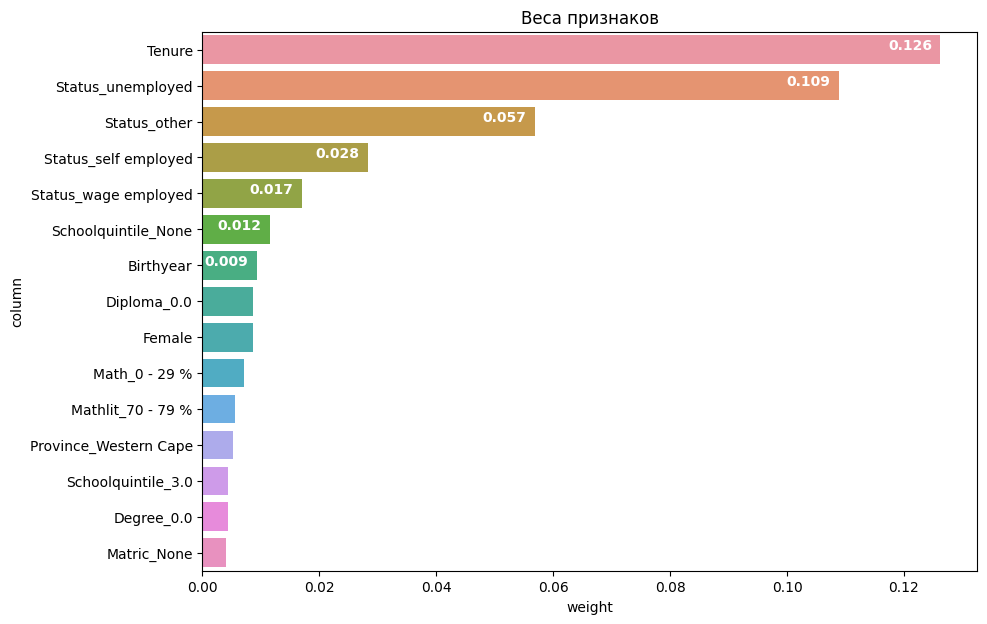

In [31]:
# Выведем наиболее значимые признаки, веса на график
from sklearn.inspection import permutation_importance

r = permutation_importance(lgb_bin,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)
feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['weight'] = r['importances_mean']

feature_imp.sort_values(by='weight', inplace=True, ascending=False)

plt.figure(figsize=(10, 7))
plt.title('Веса признаков', fontsize=12)
sns.barplot(data=feature_imp[:15], x='weight', y='column')

# Выведем значения весов на бары
for index, value in enumerate((feature_imp['weight'])):
    label = format(f"{value:.3f}")
    plt.annotate(label, xy = (value-0.009, index), color='white',fontweight='bold')

Наиболее весомый признак - длительность статуса. Потом идет статус - безработный или занятый.<br>
В разевдочном анализе эти признаки были важны:
длительность статуса (кто дольше безработный, тот скорее устроится, и у кого маленький стаж, у того больше шансов потерять работу), статус (тот, кто уже работает по найму или на себя, так и будет работать, а кто безарботный, тот с трудом найдет и в течение года потеряет).<br>
Так же уровни образования мало значимы для определения целевого признака. Даже на графике значение "не определен" для уровня школьного образования более значим, чем остальные.

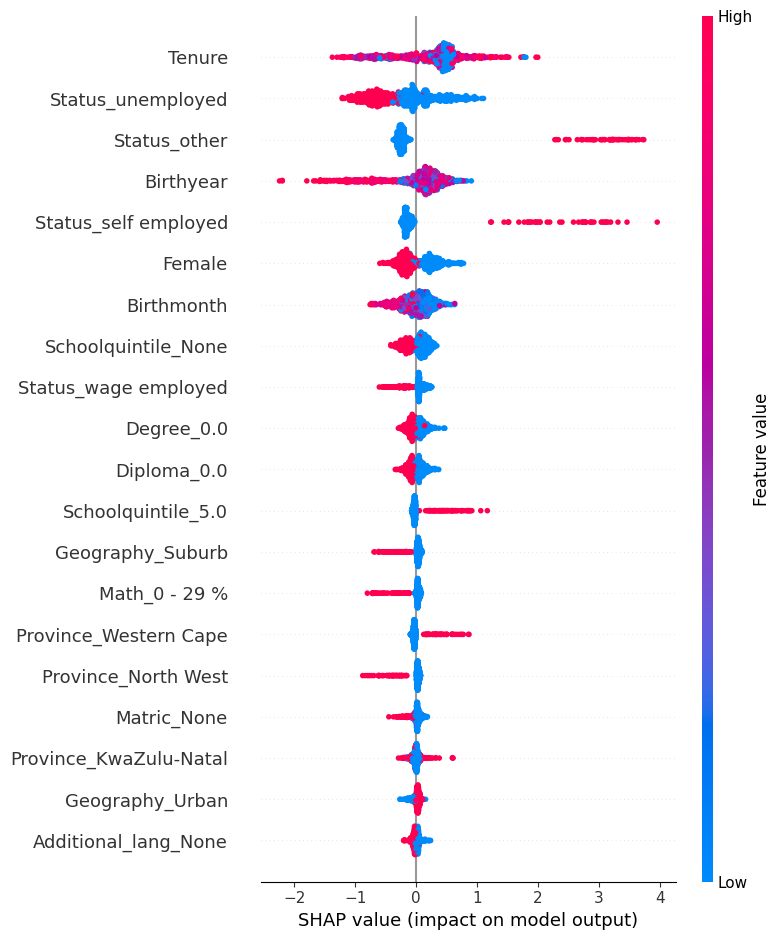

In [32]:
explainer = shap.TreeExplainer(lgb_bin)
shap_values = explainer(X_test)
cl = shap_values[:, :, 1]
shap.summary_plot(cl, X_test)

Интерпертация Шепли даёт один из портретов человека, который скорее всего не пойдет работать в течение года. <br>Это молодая женщина без высшего образования из пригорода провинции  North West, которая недавно стала безработная или недавно работает по найму, при этом не учится. В школе у неё. был низкий балл по математике.<br> Так же портрет одного из людей, который будет работать в течение года. <br>
Это  мужчина старше 23 лет из столичной провинции Western Cape или KwaZulu-Natal, долгое время самозанятый, или как-либо ещё, но не наёмный и не студент. У него не больше, чем школьное образование, причем школа частная и в числе самых дорогих. Уровень знания математики больше 30% по школьной системе ЮАР.<br>
Распределение между мужчинами и женщинами имеет лишь некоторый перевес в сторону женщин, поэтому для описательного портрета его используем.